In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [ ]:

###############################################################
#               Pre Processing data 
############################################################### 

df = pd.read_csv("C:/Users/Jun/Desktop/VSCODE/Parlay/Synthetic_SBA_Loans.csv")

avg_score = df['Eligibility Score'].mean()
below_avg = df[df['Eligibility Score'] < avg_score]
n_decline = int(0.25 * len(df))
decline_indices = below_avg.sample(n=n_decline, random_state=42).index
df.loc[decline_indices, 'Eligibility'] = '0'
eligibility_counts = df['Eligibility'].value_counts()
eligibility_counts

Eligibility
['7(a)', '504']    446766
0                  148921
Name: count, dtype: int64

In [3]:
df['Eligibility'] = df['Eligibility'].apply(lambda x: 1 if x == "['7(a)', '504']" else 0)
df['Eligibility'].value_counts()

Eligibility
1    446766
0    148921
Name: count, dtype: int64

In [4]:

###############################################################
#               Column Selection
############################################################### 

selected_columns = [
    'Business Ownership (1)', 'Business Ownership (2)', 'Business Ownership (3)',
    'Business Ownership (4)', 'Business Ownership (5)', 'Annual Revenue (2 years ago)',
    'Annual Revenue (1 year ago)', 'Annual Revenue (latest year)', 'Net Profit Margin',
    'Business Debt (2 years ago)', 'Business Debt (1 year ago)', 'Business Debt (latest year)',
    'NOI (2 years ago)', 'NOI (1 year ago)', 'NOI (latest year)', 'Managerial Experience',
    'Years in Business', 'Collateral Availability', 'Acquisition Request', 'Working Capital',
    'Business Expansion', 'Equipment Purchase or Leasing', 'Inventory Purchase',
    'Real Estate Acquisition or Improvement', 'Business Acquisition or Buyout',
    'Refinancing Existing Debt', 'Emergency Funds', 'Franchise Financing',
    'Contract Financing', 'Licensing or Permits', 'Line of Credit Establishment',
    'Eligibility Score'
]
X = df[selected_columns]
y = df['Eligibility']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train.shape, X_test.shape, y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)

((476549, 32),
 (119138, 32),
 Eligibility
 1    0.750001
 0    0.249999
 Name: proportion, dtype: float64,
 Eligibility
 1    0.750004
 0    0.249996
 Name: proportion, dtype: float64)

In [6]:

numerical_cols = X_train.select_dtypes(include=['int64', 'float64', 'bool']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols)
    ]
)

preprocessing_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

X_train_preprocessed = preprocessing_pipeline.fit_transform(X_train)
X_test_preprocessed = preprocessing_pipeline.transform(X_test)

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

###############################################################
#               Neural Network
############################################################### 
lr = 0.0005
epoch = 20

early_stopping = EarlyStopping(
    monitor='val_loss',   
    patience=3,           
    restore_best_weights=True 
)

input_shape = X_train_preprocessed.shape[1]

model = Sequential([
    Dense(128, activation='relu', input_shape=(input_shape,)),
    BatchNormalization(),
    Dropout(0.2),  
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  
])

model.compile(optimizer=Adam(learning_rate=lr),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train_preprocessed, y_train,
                    validation_split=0.1,
                    epochs=epoch,
                    batch_size=128,
                    verbose=1,
                    callbacks=[early_stopping]) 

test_loss, test_acc = model.evaluate(X_test_preprocessed, y_test)
print(f"Test Accuracy: {test_acc:.4f}")


Epoch 1/20


c:\Users\Jun\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3351/3351 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7412 - loss: 0.4327 - val_accuracy: 0.7737 - val_loss: 0.3365
Epoch 2/20
3351/3351 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7719 - loss: 0.3471 - val_accuracy: 0.7758 - val_loss: 0.3315
Epoch 3/20
3351/3351 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7739 - loss: 0.3391 - val_accuracy: 0.7774 - val_loss: 0.3279
Epoch 4/20
3351/3351 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7773 - loss: 0.3330 - val_accuracy: 0.7791 - val_loss: 0.3259
Epoch 5/20
3351/3351 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7772 - loss: 0.3296 - val_accuracy: 0.7792 - val_loss: 0.3257
Epoch 6/20
3351/3351 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7778 - loss: 0.3283 - val_accuracy: 0.7794 - val_loss: 0.3259
Epoch 7/20
3351/3351 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7770 - loss: 0.3281 - val_accuracy: 0.7793 - val_loss: 0.3257
Epoch 8/20
3351/3351 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7780 - loss: 0.3273 - val_accurac

In [10]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier


###############################################################
#               Checking Column Weights
############################################################### 


rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_preprocessed, y_train)

feature_importances = rf_model.feature_importances_
num_features = preprocessing_pipeline.named_steps['preprocessor'].transformers_[0][2]  
feature_names = list(num_features)

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df.head(20))




                         Feature  Importance
31             Eligibility Score    0.316057
11   Business Debt (latest year)    0.052609
14             NOI (latest year)    0.048051
8              Net Profit Margin    0.046537
7   Annual Revenue (latest year)    0.045334
5   Annual Revenue (2 years ago)    0.044412
6    Annual Revenue (1 year ago)    0.044305
9    Business Debt (2 years ago)    0.043380
10    Business Debt (1 year ago)    0.043282
12             NOI (2 years ago)    0.043255
13              NOI (1 year ago)    0.043188
16             Years in Business    0.037642
15         Managerial Experience    0.034348
0         Business Ownership (1)    0.018241
18           Acquisition Request    0.018124
1         Business Ownership (2)    0.018029
19               Working Capital    0.017080
29          Licensing or Permits    0.006799
20            Business Expansion    0.006793
25     Refinancing Existing Debt    0.006791


3724/3724 ━━━━━━━━━━━━━━━━━━━━ 3s 816us/step
Brier Score (lower is better): 0.1175


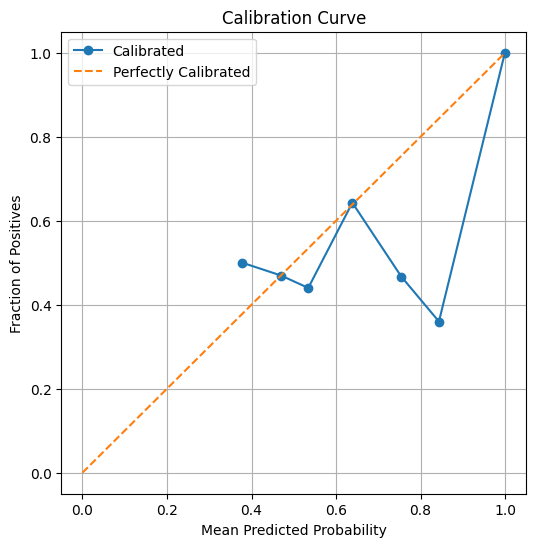

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt



###############################################################
#               Ccalibrator check
############################################################### 

val_probs = model.predict(X_test_preprocessed)
val_probs = val_probs.flatten()  

calibrator = LogisticRegression()
calibrator.fit(val_probs.reshape(-1, 1), y_test)
calibrated_probs = calibrator.predict_proba(val_probs.reshape(-1, 1))[:, 1]

brier = brier_score_loss(y_test, calibrated_probs)
print(f"Brier Score (lower is better): {brier:.4f}")

prob_true, prob_pred = calibration_curve(y_test, calibrated_probs, n_bins=10)

plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Calibrated')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend()
plt.grid(True)
plt.show()


In [14]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

###############################################################
#              XGBoost call
############################################################### 
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.05, random_state=42)
xgb_model.fit(X_train_preprocessed, y_train)

nn_probs = model.predict(X_test_preprocessed).flatten() 
xgb_probs = xgb_model.predict_proba(X_test_preprocessed)[:, 1]

blended_probs = (nn_probs + xgb_probs) / 2
blended_preds = (blended_probs >= 0.5).astype(int)  

blended_accuracy = accuracy_score(y_test, blended_preds)
blended_accuracy


3724/3724 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


0.7784250197250248

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


###############################################################
#               XGBoost + NN
############################################################### 

xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.05, random_state=42)
xgb_model.fit(X_train_preprocessed, y_train)

nn_train_probs = model.predict(X_train_preprocessed).flatten()  
xgb_train_probs = xgb_model.predict_proba(X_train_preprocessed)[:, 1]  

meta_X_train = np.column_stack((nn_train_probs, xgb_train_probs))
meta_y_train = y_train 
meta_learner = LogisticRegression()
meta_learner.fit(meta_X_train, meta_y_train)

nn_test_probs = model.predict(X_test_preprocessed).flatten()
xgb_test_probs = xgb_model.predict_proba(X_test_preprocessed)[:, 1]

meta_X_test = np.column_stack((nn_test_probs, xgb_test_probs))
meta_preds = meta_learner.predict(meta_X_test)
meta_accuracy = accuracy_score(y_test, meta_preds)
print(f"Meta-Learner Test Accuracy: {meta_accuracy:.4f}")


14893/14893 ━━━━━━━━━━━━━━━━━━━━ 10s 663us/step
3724/3724 ━━━━━━━━━━━━━━━━━━━━ 3s 727us/step
Meta-Learner Test Accuracy: 0.7725


In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


###############################################################
#               XGBoost + NN using RF
############################################################### 

xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.05, random_state=42)
xgb_model.fit(X_train_preprocessed, y_train)

nn_train_probs = model.predict(X_train_preprocessed).flatten()  
xgb_train_probs = xgb_model.predict_proba(X_train_preprocessed)[:, 1]  

meta_X_train = np.column_stack((nn_train_probs, xgb_train_probs))
meta_y_train = y_train  # True labels
meta_learner = RandomForestClassifier(n_estimators=100, random_state=42)
meta_learner.fit(meta_X_train, meta_y_train)

nn_test_probs = model.predict(X_test_preprocessed).flatten()
xgb_test_probs = xgb_model.predict_proba(X_test_preprocessed)[:, 1]

meta_X_test = np.column_stack((nn_test_probs, xgb_test_probs))
meta_preds = meta_learner.predict(meta_X_test)
meta_accuracy = accuracy_score(y_test, meta_preds)
print(f"Advanced Meta-Learner (Random Forest) Test Accuracy: {meta_accuracy:.4f}")


14893/14893 ━━━━━━━━━━━━━━━━━━━━ 13s 883us/step
3724/3724 ━━━━━━━━━━━━━━━━━━━━ 3s 672us/step
Advanced Meta-Learner (Random Forest) Test Accuracy: 0.7670


In [16]:
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score



###############################################################
#               LIghtGBM + NN
############################################################### 


lgb_model = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.05, random_state=42)
lgb_model.fit(X_train_preprocessed, y_train)

nn_train_probs = model.predict(X_train_preprocessed).flatten()
lgb_train_probs = lgb_model.predict_proba(X_train_preprocessed)[:, 1]

meta_X_train = np.column_stack((nn_train_probs, lgb_train_probs))
meta_learner = LogisticRegression()
meta_learner.fit(meta_X_train, y_train)

nn_test_probs = model.predict(X_test_preprocessed).flatten()
lgb_test_probs = lgb_model.predict_proba(X_test_preprocessed)[:, 1]

meta_X_test = np.column_stack((nn_test_probs, lgb_test_probs))
meta_preds = meta_learner.predict(meta_X_test)
meta_accuracy = accuracy_score(y_test, meta_preds)

print(f"Meta-Learner (NN + LightGBM) Test Accuracy: {meta_accuracy:.4f}")


[LightGBM] [Info] Number of positive: 357412, number of negative: 119137
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2818
[LightGBM] [Info] Number of data points in the train set: 476549, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.750001 -> initscore=1.098615
[LightGBM] [Info] Start training from score 1.098615
14893/14893 ━━━━━━━━━━━━━━━━━━━━ 11s 748us/step


c:\Users\Jun\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


3724/3724 ━━━━━━━━━━━━━━━━━━━━ 3s 764us/step
Meta-Learner (NN + LightGBM) Test Accuracy: 0.7723


c:\Users\Jun\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [17]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

###############################################################
#               XGBoost + LightGBM + NN
############################################################### 
nn_train_probs = model.predict(X_train_preprocessed).flatten()
xgb_train_probs = xgb_model.predict_proba(X_train_preprocessed)[:, 1]
lgb_train_probs = lgb_model.predict_proba(X_train_preprocessed)[:, 1]

meta_X_train = np.column_stack((nn_train_probs, xgb_train_probs, lgb_train_probs))
meta_y_train = y_train

meta_learner = LogisticRegression()
meta_learner.fit(meta_X_train, meta_y_train)

nn_test_probs = model.predict(X_test_preprocessed).flatten()
xgb_test_probs = xgb_model.predict_proba(X_test_preprocessed)[:, 1]
lgb_test_probs = lgb_model.predict_proba(X_test_preprocessed)[:, 1]

meta_X_test = np.column_stack((nn_test_probs, xgb_test_probs, lgb_test_probs))
meta_preds = meta_learner.predict(meta_X_test)
meta_accuracy = accuracy_score(y_test, meta_preds)
print(f"Meta-Learner (NN + XGB + LGBM) Test Accuracy: {meta_accuracy:.4f}")



14893/14893 ━━━━━━━━━━━━━━━━━━━━ 13s 852us/step


c:\Users\Jun\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


3724/3724 ━━━━━━━━━━━━━━━━━━━━ 3s 825us/step
Meta-Learner (NN + XGB + LGBM) Test Accuracy: 0.7717


c:\Users\Jun\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [21]:
import joblib

###############################################################
#               Model Saving
############################################################### 
print(meta_learner.coef_)
model.save("neural_net_model.h5")  
joblib.dump(xgb_model, "xgboost_model.pkl") 
joblib.dump(meta_learner, "meta_learner.pkl")  



[[10.35089515 17.42123358 20.07461631]]


['meta_learner.pkl']

In [20]:

# Step 1: Rebuild the preprocessing pipeline using training data (df_train)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_cols),
])


import joblib
joblib.dump(preprocessor, 'preprocessor.pkl')


['preprocessor.pkl']

In [22]:
from tensorflow.keras.models import load_model

model = load_model("neural_net_model.h5")
print(model.input_shape)  # Example output: (None, 32)

(None, 32)
